# Smallest eigenvalue problem

$\newcommand{\mapcom}[5]{\begin{align*} #1 \,:\, #2& \longrightarrow #3 \\ #4& \longmapsto #5, \end{align*}}$
$\newcommand{\Rset}{\mathbb{R}}$
We look here at the case where we would like to find the smallest eigenvalue of a real symmetric parameterized matrix $$\mapcom{A}{\mathcal{P}\subset\Rset^p}{\Rset^{n\times n}}{\mu}{A(\mu)}$$ with eigenvalues $\lambda_1< \dots\le\lambda_n$. The parameter space $\mathcal{P}$ is considered to be an open bounder connected subset of $\Rset^p$. 
The smallest eigenvalue $\lambda_1=\lambda_1(\mu)\in\Rset$, can be determined by the study of the Rayleigh quotient as follow 
$$
	\lambda_1(\mu) = \min_{x\in\Rset^n} \frac{x^TA(\mu)x}{x^Tx} = \min_{x^Tx = 1} x^TA(\mu)x.
$$
Therefore by defining a cost function $$\mapcom{f}{S^{n-1}\times\mathcal{P}}{\Rset}{(x,\mu)}{\frac{1}{2}x^TA(\mu)x}$$ the problem is equivalent to solving the following minimization problem
$$
	\lambda_1 = \min_{x \in S^{n-1}} f(x,\mu).
$$

##############################################################################################################
##############################################################################################################

## First test case, $n=3, p=2$, smooth eigenvalues: 
We consider a mapping $A$ defined for any $\mu=(\mu_1, \mu_2)\in\Rset^2$ by 

$$
A(\mu) = \begin{pmatrix} \lambda_1(\mu) & -1 & 0 \\ -1 & \lambda_2(\mu) & 1 \\ 0 & 1 & \lambda_3(\mu) \end{pmatrix},
$$

with $\lambda_1(\mu) = 1 + \exp(\frac{\mu_1 - \mu_2}{\sigma}), \lambda_2(\mu) = 2 + \exp(\frac{3\mu_1 + \mu_2}{\sigma}), \lambda_3(\mu) = 3 + \exp(\frac{\mu_1 + \mu_2}{\sigma})$, $\sigma \in\Rset$.

In [1]:
import autograd.numpy as np

In [2]:
from pymanopt.manifolds import Sphere

# Dimension of the sphere 
solutionSpaceDimension = 3

# Instantiate the unit sphere manifold
unitSphere = Sphere(solutionSpaceDimension)

In [3]:
from pymanopt.manifolds import Euclidean

# Dimension of the parameter space 
parameterSpaceDimension = 2

# Instantiate the parameter space 
parameterSpace = Euclidean(parameterSpaceDimension)

In [4]:
from pymanopt.manifolds import Product

productManifold = Product([unitSphere, parameterSpace])

## Computation of  $DA(\mu)[v]$

Here we give an explicit form for the differential of $A$ at $\mu\in\mathcal{P}$ along $v\in\mathcal{P}$. We have that 

$$
    DA(\mu)[v] = \begin{pmatrix} \frac{v_1 - v_2}{\sigma} \exp(\frac{\mu_1 - \mu_2}{\sigma}) & & \\ & \frac{3v_1 + v_2}{\sigma} \exp(\frac{3\mu_1 + \mu_2}{\sigma}) & \\ & & \frac{v_1 + v_2}{\sigma} \exp(\frac{\mu_1 + \mu_2}{\sigma}) \end{pmatrix}
$$

In [5]:
def A(mu):
    sigma = 100
    lambda0 = 1 + np.exp((mu[0] - mu[1]) / sigma)
    lambda1 = 2 + np.exp((3 * mu[0] + mu[1]) / sigma)
    lambda2 = 3 + np.exp((mu[0] + mu[1]) / sigma)
    
    return np.array([[lambda0, -1, 0], [-1, lambda1, -1], [0, -1, lambda2]])

def DA(mu,v):
    sigma = 100
    Dlambda0 = (v[0] - v[1]) / sigma * np.exp((mu[0] - mu[1]) / sigma)
    Dlambda1 = (3 * v[0] + v[1]) / sigma * np.exp((3 * mu[0] + mu[1]) / sigma)
    Dlambda2 = (v[0] + v[1]) / sigma * np.exp((mu[0] + mu[1]) / sigma)
    
    return np.array([[Dlambda0, 0, 0], [0, Dlambda1, 0], [0, 0, Dlambda2]])

### Compute $D_x\operatorname{grad} f(x,\mu)$ and $D_\mu\operatorname{grad} f(x,\mu)$ 

In [6]:
# Define derivatives of gradient wrt solution/parameter

def differentialSolutionAlongV(x, mu, xi):
    return A(mu) @ xi - 2 * (x.T @ A(mu) @ xi) * x - (x.T @ A(mu) @ x) * xi

#def differentialParameterAlongV(x, mu, v):
#    return np.eye(solutionSpaceDimension)
def differentialParameterAlongV(x, mu, v):
    return (np.eye(solutionSpaceDimension) - np.outer(x, x)) @ DA(mu, v) @ x
    

### Define cost function $f$ and instantiate optimization problem

In [7]:
from pymanopt.core.problem import Problem 

def cost(S):
    return np.dot(S[0], A(S[1]) @ S[0])

problem = Problem(productManifold, cost=cost)

### Define initial/target parameters and initial solution to the problem 

In [8]:
initialParameter = np.array([1, 2])
targetParameter = np.array([23., 30.])

B = A(initialParameter)
C = A(targetParameter)

w, v = np.linalg.eig(B)
wC, vC = np.linalg.eig(C)

initialSolution = v[:, np.argmin(w)]
finalSolution = vC[:, np.argmin(wC)]

In [9]:
from Continuation.PathAdaptiveContinuation import PathAdaptiveMultiParameterContinuation

parameterMagnitude =  0.5 * 1e-1

# Instantiate continuation object
continuation = PathAdaptiveMultiParameterContinuation(problem, 
                                                      initialSolution,
                                                      initialParameter,
                                                      targetParameter,
                                                      differentialSolutionAlongV, 
                                                      differentialParameterAlongV,
                                                      A,
                                                      parameterMagnitude)
results = continuation.Traverse()

Compiling cost function...
Computing gradient of cost function...



========== New continuation problem ==========

Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+4.0505651337275708e+02	6.17408299e+01
    2	+4.0461442536793948e+02	3.34114485e+01
    3	+4.0443877390799287e+02	6.86742625e+00
    4	+4.0443238396887728e+02	2.86982884e+00
    5	+4.0443107622804303e+02	5.20560064e-01
    6	+4.0443106291716578e+02	4.35779944e-01
    7	+4.0443103240456389e+02	6.36899775e-02
    8	+4.0443103186272867e+02	2.74983073e-02
    9	+4.0443103173961424e+02	2.50592144e-03
   10	+4.0443103173935623e+02	2.16973509e-03
   11	+4.0443103173866871e+02	7.21147599e-04
   12	+4.0443103173858327e+02	4.71259320e-06
   13	+4.0443103173858327e+02	8.76679989e-06
Terminated - min stepsize reached after 13 iterations, 0.01 seconds.

Computing Hessian of cost function...
Optimizing...
                                            f: +2.137700e+03   |grad|: 2.150

 --> Maximum step size exceeded.

 --> End of continuation exceeded

Next step size = 1


----- Step 2, L = 1 -----

Compiling cost function...
Computing gradient of cost function...
f_0 = 1.375440888808336
|gradf_0| = 0.41547798527536534
f_1 = 1.362979562021381
|gradf_1| = 0.3272415273339134
f_2 = 1.3550709569660067
|gradf_2| = 0.006784783619352193
f_3 = 1.3550678135617953
|gradf_3| = 4.2425421513367804e-05
f_4 = 1.3550678133314686
|gradf_4| = 9.886909086225508e-07
Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+1.2248950233827775e+02	7.65386921e+01
    2	+1.2187713154981131e+02	3.72959633e+01
    3	+1.2175555145456406e+02	2.25004312e+01
    4	+1.2172515741069533e+02	1.68694390e+01
    5	+1.2169816797513596e+02	9.38223136e+00
    6	+1.2168625369532597e+02	1.09837285e+00
    7	+1.2168609066884434e+02	1.36500519e-01
    8	+1.2168609062902340e+02	1.35433294e-01
    9	+1.2168609047225912e+02	1.31148755e-01
   10	+1.216860898868423

f_1 = 1.4806639566330542
|gradf_1| = 0.5321333712090561
f_2 = 1.461159370041261
|gradf_2| = 0.0015607501306152103
f_3 = 1.4611591601071527
|gradf_3| = 1.6456927898529368e-05
f_4 = 1.46115916008017
|gradf_4| = 1.0250598843951034e-07
Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+8.0674369566344843e+00	1.32432630e+01
    2	+8.0517273062655281e+00	5.19967827e+00
    3	+8.0492595288506852e+00	1.93251308e+00
    4	+8.0489880173177610e+00	1.08202535e+00
    5	+8.0488651462206899e+00	1.02696744e-01
    6	+8.0488646065664415e+00	7.38296647e-02
    7	+8.0488644659715689e+00	6.42123424e-02
    8	+8.0488640846671231e+00	2.28621418e-02
    9	+8.0488640581821471e+00	1.65102270e-02
   10	+8.0488640494385209e+00	1.37849230e-02
   11	+8.0488640296600806e+00	1.80610896e-03
   12	+8.0488640295297706e+00	1.42532057e-03
   13	+8.0488640293242355e+00	3.01279320e-04
   14	+8.0488640293157108e+00	1.01338843e-04
   15	+8.0488640293156255e+00	9.724394

# Visualization of results

<IPython.core.display.Javascript object>


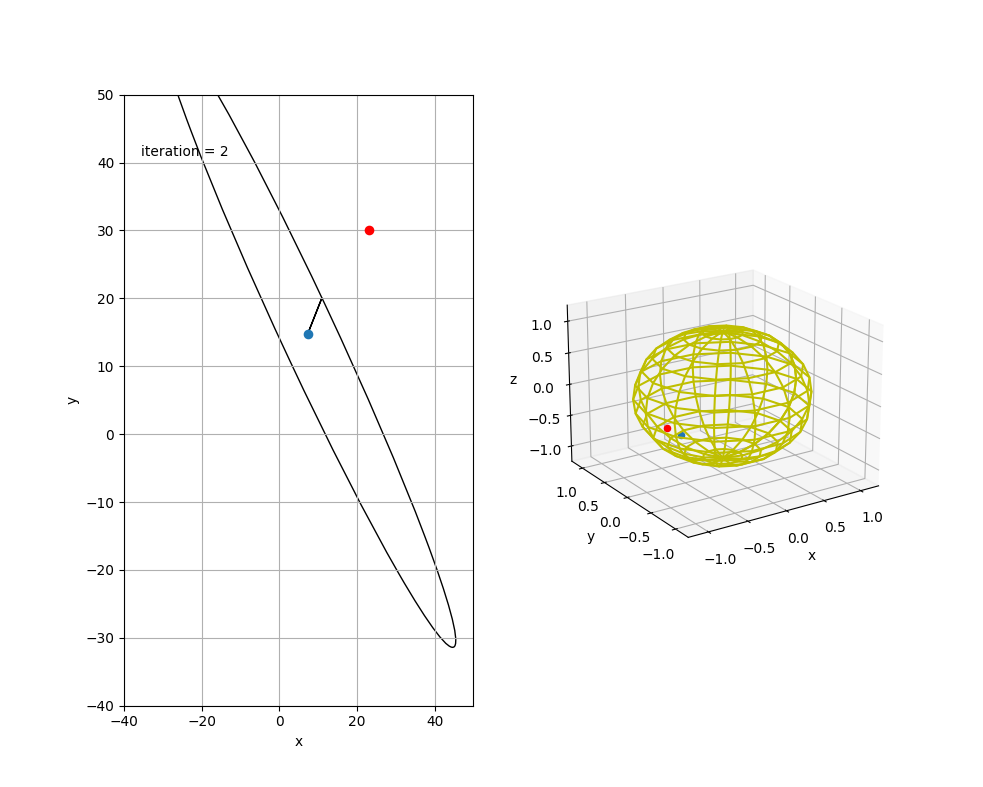

[8.78993325e-07 4.90326197e-05]


In [10]:
%matplotlib notebook
from Visualization.visualization import SubplotAnimation

ani = SubplotAnimation(results, 
                       parameterMagnitude, 
                       targetParameter, 
                       finalSolution, 
                       differentialParameterAlongV, 
                       differentialSolutionAlongV)

ani.show()

############################################################################################################################
############################################################################################################################

## Second test case, $n=3, p=2$, $C^0$ eigenvalues: 
We consider a mapping $A$ defined for any $\mu=(\mu_1, \mu_2)\in\Rset^2$ by 

$$
A(\mu) = \begin{pmatrix} \lambda_1(\mu) & -1 & 0 \\ -1 & \lambda_2(\mu) & 1 \\ 0 & 1 & \lambda_3(\mu) \end{pmatrix},
$$

with 
$$
\lambda_0(\mu) = 
\begin{cases}
    1 + \exp(\frac{\mu_1 + \mu_2}{\sigma}) \quad &\text{if } \mu_1 + \mu_2 \le 0,\\
    1 + \exp(\frac{\mu_1 + \mu_2}{10\sigma}) &\text{else }
\end{cases} , 
\lambda_1(\mu) = 
\begin{cases}
    2 + \exp(\frac{\mu_1 - \mu_2}{\sigma}) \quad &\text{if } \mu_1 - \mu_2 \le 0,\\
    2 + \exp(\frac{\mu_1 - \mu_2}{10\sigma}) &\text{else }
\end{cases},
$$
$$
\lambda_2(\mu) = 
\begin{cases}
    3 + \exp(\frac{3\mu_1 + \mu_2}{\sigma}) \quad &\text{if } 3\mu_1 + \mu_2 \le 0,\\
    3 + \exp(\frac{3\mu_1 + \mu_2}{10\sigma}) &\text{else }
\end{cases} 
$$

In [5]:
def A(mu):
    sigma = 50
    
    if mu[0] + mu[1] <= 0:
        lambda0 = 1 + np.exp((mu[0] + mu[1]) / sigma)
    else:
        lambda0 = 1 + np.exp((mu[0] + mu[1]) / (10 * sigma))
        
    if mu[0] - mu[1] <= 0:
        lambda1 = 2 + np.exp((mu[0] - mu[1]) / sigma)
    else:
        lambda1 = 2 + np.exp((mu[0] - mu[1]) / (5 * sigma))

    if 3 * mu[0] + mu[1] <= 0:
        lambda2 = 3 + np.exp((3 * mu[0] + mu[1]) / sigma)
    else:
        lambda2 = 3 + np.exp((3 * mu[0] + mu[1]) / (20 * sigma))
        
    return np.array([[lambda0, -1, 0], [-1, lambda1, -1], [0, -1, lambda2]])

def DA(mu, v):
    tol = 1.0e-15
    sigma = 50
    
    if np.abs(mu[0] + mu[1]) <= tol:
        Dlambda0 = np.nan
    elif mu[0] + mu[1] < 0:
        Dlambda0 = (1.0 / sigma) * (v[0] + v[1]) * np.exp((mu[0] + mu[1]) / sigma)
    else:
        Dlambda0 = (1.0 / (10.0 * sigma)) * (v[0] + v[1]) * np.exp((mu[0] + mu[1]) / (10.0 * sigma))
        
    if np.abs(mu[0] - mu[1]) <= tol:
        Dlambda1 = np.nan
    elif mu[0] - mu[1] < 0:
        Dlambda1 = (v[0] - v[1]) / sigma * np.exp((mu[0] - mu[1]) / sigma)
    else:
        Dlambda1 = (v[0] - v[1]) / (5 * sigma) * np.exp((mu[0] - mu[1]) / (5 * sigma))

    if np.abs(3 * mu[0] + mu[1]) <= tol:
        Dlambda2 = np.nan
    elif 3 * mu[0] + mu[1] < 0:
        Dlambda2 = (3 * v[0] + v[1]) / sigma * np.exp((3 * mu[0] + mu[1]) / sigma)
    else:
        Dlambda2 = (3 * v[0] + v[1]) / (20 * sigma) * np.exp((3 * mu[0] + mu[1]) / (20.0 * sigma))

    
    return np.array([[Dlambda0, 0, 0], [0, Dlambda1, 0], [0, 0, Dlambda2]])

In [6]:
# Define derivatives of gradient wrt solution/parameter
def differentialSolutionAlongV(x, mu, xi):
    return A(mu) @ xi - 2 * (x.T @ A(mu) @ xi) * x - (x.T @ A(mu) @ x) * xi

def differentialParameterAlongV(x, mu, v):
    return (np.eye(solutionSpaceDimension) - np.outer(x, x)) @ DA(mu, v) @ x

In [7]:
initialParameter = np.array([0, -5])
targetParameter = np.array([40., 40.])

B = A(initialParameter)
C = A(targetParameter)

w, v = np.linalg.eig(B)
wC, vC = np.linalg.eig(C)

initialSolution = v[:, np.argmin(w)]
finalSolution = vC[:, np.argmin(wC)]

In [8]:
def WriteMatrixInEuclideanBasisAtGivenPoint(matrixVectorFunction, x, mu, dimension):
    spaceDimension = len(x)
    indices = np.arange(dimension)
    A = np.zeros((spaceDimension, dimension))

    for index in indices:
        v = np.zeros(dimension)
        v[index] = 1

        A[:, index] = matrixVectorFunction(x, mu, v)

    return A

In [9]:
np.linalg.matrix_rank(WriteMatrixInEuclideanBasisAtGivenPoint(differentialParameterAlongV, initialSolution, initialParameter, 2))

2

In [10]:
from pymanopt.core.problem import Problem 

def cost(S):
    return np.dot(S[0], A(S[1]) @ S[0])

problem = Problem(productManifold, cost=cost)

In [25]:
from Continuation.PathAdaptiveContinuation import PathAdaptiveMultiParameterContinuation

parameterMagnitude = 1e-2

# Instantiate continuation object
continuation = PathAdaptiveMultiParameterContinuation(problem, 
                                                      initialSolution,
                                                      initialParameter,
                                                      targetParameter,
                                                      differentialSolutionAlongV, 
                                                      differentialParameterAlongV,
                                                      A,
                                                      parameterMagnitude)
results = continuation.Traverse()




========== New continuation problem ==========

Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+1.6876729998812209e+03	5.32553330e+01
    2	+1.6782751110692332e+03	1.30037217e+01
    3	+1.6782377436421161e+03	1.26687689e+01
    4	+1.6780983429055086e+03	1.09630594e+01
    5	+1.6777277767592479e+03	3.62404496e+00
    6	+1.6776822148951510e+03	5.71367933e-02
    7	+1.6776822140204549e+03	5.48918767e-02
    8	+1.6776822108139168e+03	4.57218771e-02
    9	+1.6776822036484514e+03	5.36434736e-03
   10	+1.6776822035498647e+03	6.40780711e-04
   11	+1.6776822035484461e+03	5.08956169e-05
   12	+1.6776822035484379e+03	1.17569394e-05
   13	+1.6776822035484374e+03	7.63004700e-07
Terminated - min grad norm reached after 13 iterations, 0.01 seconds.

Computing Hessian of cost function...
Optimizing...
                                            f: +1.897118e+03   |grad|: 1.152300e+02
acc TR+   k:     1     num_inner:     0     f: +1.848909e

acc       k:     2     num_inner:     0     f: +1.335379e+03   |grad|: 8.905984e+03   negative curvature
acc       k:     3     num_inner:     0     f: +3.348219e+02   |grad|: 1.423045e+03   maximum inner iterations
acc       k:     4     num_inner:     0     f: +3.126007e+02   |grad|: 1.285571e+01   maximum inner iterations
acc       k:     5     num_inner:     0     f: +3.125989e+02   |grad|: 1.198518e-03   maximum inner iterations
acc       k:     6     num_inner:     0     f: +3.125989e+02   |grad|: 1.047312e-11   maximum inner iterations
Terminated - min grad norm reached after 6 iterations, 0.01 seconds.

Optimizing...
 iter		   cost val	    grad. norm
    0	+2.3611221719243695e+03	1.19743905e+04
    1	+4.3043303920529354e+02	3.19582130e+03
    2	+3.1351811715958411e+02	2.87194693e+02
    3	+3.1260249041442324e+02	1.80408873e+01
    4	+3.1259888602343352e+02	1.09733686e+00
    5	+3.1259887269033840e+02	6.66108129e-02
    6	+3.1259887264120948e+02	4.04292931e-03
    7	+3.125988726

   21	+3.1471173417935910e+02	1.63630197e-04
   22	+3.1471173417935876e+02	6.71954594e-05
   23	+3.1471173417935870e+02	2.75941100e-05
   24	+3.1471173417935870e+02	1.13316427e-05
   25	+3.1471173417935870e+02	4.65338853e-06
   26	+3.1471173417935870e+02	1.91093526e-06
Terminated - min stepsize reached after 27 iterations, 0.02 seconds.

v_steepest = [-0.99431888  0.10644235]

v_trust = [-0.99431888  0.10644235]

v_cg = [ 0.99394283 -0.10989838]


 New perturbation : [-2.30985753  5.86012646]

----- Step Size Selection-----

Initial stepSize = 1

NextObj = 0.00023549616818696606

NextGrad = 0.04513522142250663


Potential new step size = 0.13333333333333333

NextObj = 0.00025008421849248563

NextGrad = 0.04650554084437754


Potential new step size = 0.17777777777777778

NextObj = 0.0002702167346280149

NextGrad = 0.04833287046038347


Potential new step size = 0.23703703703703705

NextObj = 0.00029827210332267207

NextGrad = 0.05076967493723523


Potential new step size = 0.31604938271

f_1 = 1.380990903038785
|gradf_1| = 0.06632763533389624
f_2 = 1.3806643003240695
|gradf_2| = 7.370326645922707e-05
f_3 = 1.3806642998729766
|gradf_3| = 1.1701307560331131e-07


<IPython.core.display.Javascript object>


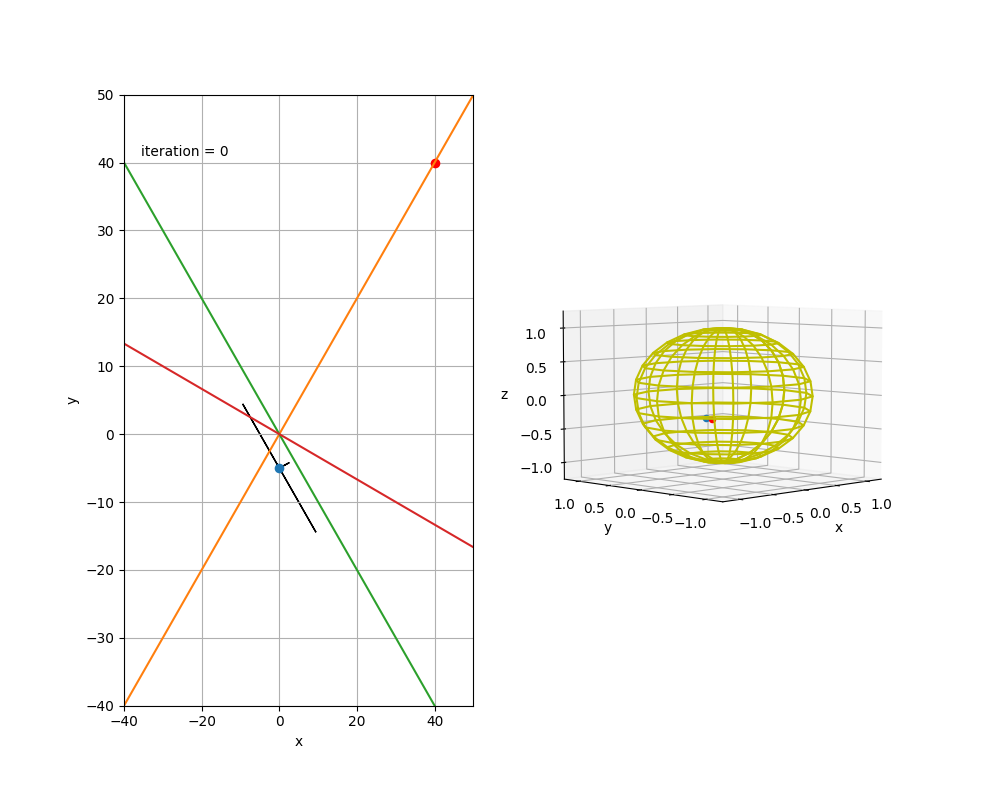

[6.34927898e-06 2.42606041e-05]


In [26]:
%matplotlib notebook
from Visualization.visualization import SubplotAnimationWithDiscontinuities

ani = SubplotAnimationWithDiscontinuities(results, 
                                          parameterMagnitude, 
                                          targetParameter, 
                                          finalSolution, 
                                          differentialParameterAlongV, 
                                          differentialSolutionAlongV)

ani.show()

## Test with sphere (classical approach)

In [23]:
from Continuation.StepSizeAdaptiveContinuation import StepSizeAdaptiveContinuation

parameterMagnitude = 8.9

# Instantiate continuation object
continuation = StepSizeAdaptiveContinuation(problem,
                                            initialSolution,
                                            initialParameter,
                                            targetParameter,
                                            differentialSolutionAlongV,
                                            differentialParameterAlongV,
                                            A,
                                            parameterMagnitude)
results = continuation.Traverse()




========== New continuation problem ==========

Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+1.3162540412437429e+03	5.68434189e-14
Terminated - min grad norm reached after 1 iterations, 0.00 seconds.

Computing Hessian of cost function...
Optimizing...
                                            f: +1.856017e+03   |grad|: 5.358367e+02
acc TR+   k:     1     num_inner:     0     f: +1.659884e+03   |grad|: 5.001874e+02   negative curvature
acc TR+   k:     2     num_inner:     0     f: +1.391985e+03   |grad|: 2.746384e+02   exceeded trust region
acc       k:     3     num_inner:     0     f: +1.316254e+03   |grad|: 8.038873e-14   maximum inner iterations
Terminated - min grad norm reached after 3 iterations, 0.01 seconds.

Optimizing...
 iter		   cost val	    grad. norm
    0	+1.7939262109808660e+03	5.32683282e+02
    1	+1.4343024231112399e+03	3.35525344e+02
    2	+1.3197634970154968e+03	6.12272341e+01
    3	+1.317127484003

NextGrad = 0.04337252703313603


Potential new step size = 0.7491540923639689

NextObj = 0.00025724955552330897

NextGrad = 0.04850132749443408


Potential new step size = 0.9988721231519585

NextObj = 0.0003352313305728938

NextGrad = 0.0553420873504785


Potential new step size = 1.3318294975359446

NextObj = 0.00045523664187530066

NextGrad = 0.06446547965866202

 --> Maximum step size exceeded.

 --> End of continuation exceeded

Next step size = 1


----- Step 3, L = 1 -----

Compiling cost function...
Computing gradient of cost function...
f_0 = 1.3168921456213436
|gradf_0| = 0.0553011983112879
f_1 = 1.3167650733055303
|gradf_1| = 0.053240496735659566
f_2 = 1.3165565392227838
|gradf_2| = 7.200943452474505e-05
f_3 = 1.3165565386999294
|gradf_3| = 1.5976991507705797e-07
Computing gradient of cost function...
----- Step Size Selection-----

Initial stepSize = 1

NextObj = 0.00010860251878708205

NextGrad = 0.03155426608901758


Potential new step size = 0.13333333333333333

NextObj 

f_1 = 1.3675788620772973
|gradf_1| = 0.05692568812921083
f_2 = 1.3673403393335812
|gradf_2| = 7.968446370388461e-05
f_3 = 1.3673403387006873
|gradf_3| = 2.1184903565875478e-07
Computing gradient of cost function...
----- Step Size Selection-----

Initial stepSize = 1

NextObj = 7.456138347028407e-05

NextGrad = 0.028010070173915377


Potential new step size = 0.13333333333333333

NextObj = 7.910178238734744e-05

NextGrad = 0.028730919516271214


Potential new step size = 0.17777777777777778

NextObj = 8.536437397288488e-05

NextGrad = 0.02969655073240429


Potential new step size = 0.23703703703703705

NextObj = 9.408556116308198e-05

NextGrad = 0.030991286358125876


Potential new step size = 0.3160493827160494

NextObj = 0.00010637347170505684

NextGrad = 0.03272887689735627


Potential new step size = 0.4213991769547325

NextObj = 0.0001239300561919343

NextGrad = 0.03506263625862765


Potential new step size = 0.5618655692729767

NextObj = 0.0001494235709287306

NextGrad = 0.038198

<IPython.core.display.Javascript object>


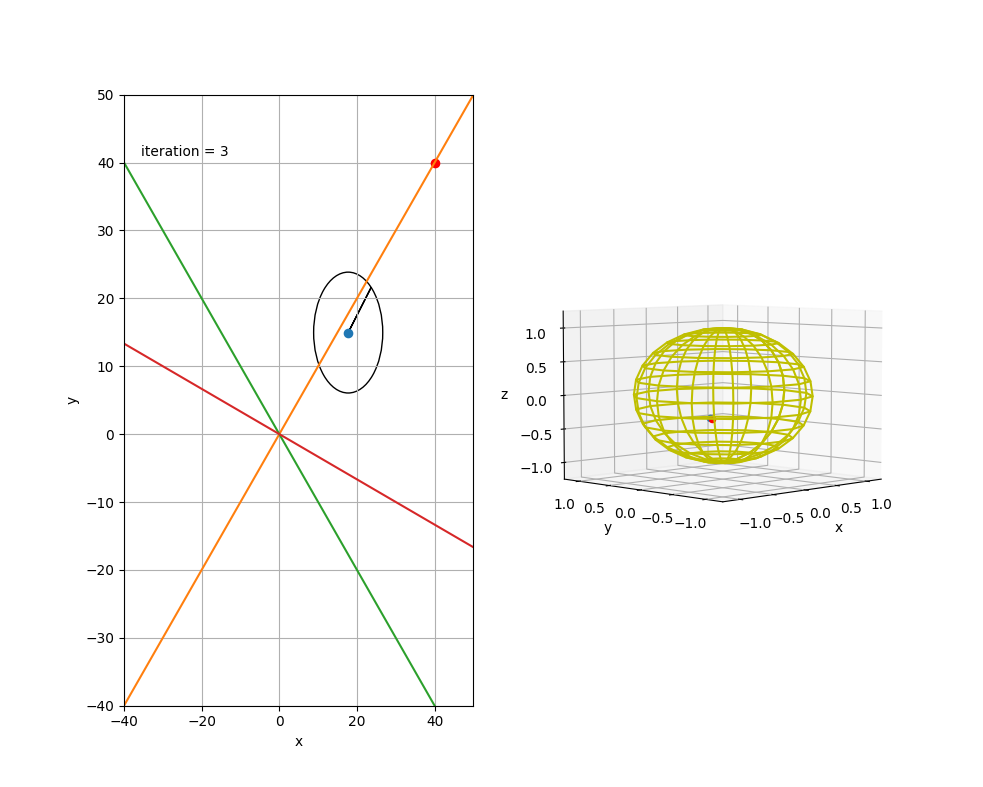

In [24]:
%matplotlib notebook
from Visualization.visualization import SubplotAnimationCircleWithDiscontinuities

ani = SubplotAnimationCircleWithDiscontinuities(results, 
                                          parameterMagnitude, 
                                          targetParameter, 
                                          finalSolution, 
                                          differentialParameterAlongV, 
                                          differentialSolutionAlongV)

ani.show()

##############################################################################################################################
##############################################################################################################################

## Third test case, $n=3, p=2$, $C^0$ eigenvalues with ill region: 
We consider a mapping $A$ defined for any $\mu=(\mu_1, \mu_2)\in\Rset^2$ by 

$$
A(\mu) = \begin{pmatrix} \lambda_1(\mu) & -1 & 0 \\ -1 & \lambda_2(\mu) & 1 \\ 0 & 1 & \lambda_3(\mu) \end{pmatrix},
$$

with 
$
\begin{align}
\lambda_0(\mu) = 
\begin{cases}
    \exp(\mu_1 + \mu_2) \quad &\text{if } \mu_1 + \mu_2 \le -\varepsilon,\\
    ax^2 + bx + c &\text{if } -\varepsilon \le \mu_1 + \mu_2 \le \varepsilon\\
    \exp(\frac{1}{\alpha(\mu_1 + \mu_2)}) &\text{if } \mu_1 + \mu_2 \ge \varepsilon.
\end{cases} 
\end{align},$

for suited $a,b,c$ and for given $\alpha, \varepsilon \in\Rset$

In [27]:
alpha = 0.2
eps = 3.

def A(mu):
    
    b = 1.0 / (2 * eps) * (np.exp(1.0 / (alpha*eps)) - np.exp(-eps))
    a = b / (2 * eps)
    c = (1.0 / 4) * (np.exp(1.0 / (alpha*eps)) + 3 * np.exp(-eps))
    
    if mu[0] + mu[1] <= -eps:
        lambda0 = 1 + np.exp((mu[0] + mu[1]))
    elif mu[0] + mu[1] >= eps:
        lambda0 = 1 + np.exp(1.0 / (alpha * (mu[0] + mu[1])))
    else:
        lambda0 = a * (mu[0] + mu[1]) ** 2 + b * (mu[0] + mu[1]) + c + 1
        
    if mu[0] - mu[1] <= -eps:
        lambda1 = 2 + np.exp((mu[0] - mu[1]))
    elif mu[0] + mu[1] >= eps:
        lambda1 = 2 + np.exp(1.0 / (alpha * (mu[0] - mu[1])))
    else:
        lambda1 = a * (mu[0] + mu[1]) ** 2 + b * (mu[0] + mu[1]) + c + 2 

        
    if 3 * mu[0] + mu[1] <= -eps:
        lambda2 = 3 + np.exp(3 * mu[0] + mu[1])
    elif 3 * mu[0] + mu[1] >= eps:
        lambda2 = 3 + np.exp(1.0 / (alpha * (3 * mu[0] + mu[1])))
    else:
        lambda2 = a * (3 * mu[0] + mu[1]) ** 2 + b * (3 * mu[0] + mu[1]) + c + 3 
        
    return np.array([[lambda0, -1, 0], [-1, lambda1, -1], [0, -1, lambda2]])

def DA(mu, v):
    tol = 1.0e-15
    
    b = 1.0 / (2 * eps) * (np.exp(1.0 / (alpha*eps)) - np.exp(-eps))
    a = b / (2 * eps)
    c = (1.0 / 4) * (np.exp(1.0 / (alpha*eps)) + 3 * np.exp(-eps))
    
    if np.abs(mu[0] + mu[1]) <= eps:
        Dlambda0 = np.nan
    elif mu[0] + mu[1] <= -eps:
        Dlambda0 = (v[0] + v[1]) * np.exp((mu[0] + mu[1]))
    elif mu[0] + mu[1] >= eps:
        Dlambda0 = (-1.0 / (alpha * (mu[0] + mu[1])**2)) * (v[0] + v[1]) * np.exp(1.0 / (alpha * (mu[0] + mu[1])))
    else:
        Dlambda0 = 2 * a * (mu[0] + mu[1]) + b
        
    if np.abs(mu[0] - mu[1]) <= eps:
        Dlambda1 = np.nan    
    elif mu[0] - mu[1] <= -eps:
        Dlambda1 = (v[0] - v[1]) * np.exp((mu[0] - mu[1]))
    elif mu[0] + mu[1] >= eps:
        Dlambda1 = (-1.0 / (alpha * (mu[0] - mu[1])**2)) * (v[0] - v[1]) * np.exp(1.0 / (alpha * (mu[0] - mu[1])))
    else:
        Dlambda1 = 2 * a * (mu[0] - mu[1]) + b

    if np.abs(3 * mu[0] + mu[1]) <= eps:
        Dlambda2 = np.nan
    if 3 * mu[0] + mu[1] <= -eps:
        Dlambda2 = (3 * v[0] + v[1]) * np.exp((3 * mu[0] + mu[1]))
    elif 3 * mu[0] + mu[1] >= eps:
        Dlambda2 = (-1.0 / (alpha * (3 * mu[0] + mu[1])**2)) * (3 * v[0] + v[1]) * np.exp(1.0 / (alpha * (3 * mu[0] + mu[1])))
    else:
        Dlambda2 = 2 * a * (3 * mu[0] + mu[1]) + b

    
    return np.array([[Dlambda0, 0, 0], [0, Dlambda1, 0], [0, 0, Dlambda2]])

In [28]:
# Define derivatives of gradient wrt solution/parameter
def differentialSolutionAlongV(x, mu, xi):
    return A(mu) @ xi - 2 * (x.T @ A(mu) @ xi) * x - (x.T @ A(mu) @ x) * xi

def differentialParameterAlongV(x, mu, v):
    return (np.eye(solutionSpaceDimension) - np.outer(x, x)) @ DA(mu, v) @ x

In [35]:
initialParameter = np.array([-10., 22])
targetParameter = np.array([30., 40.1])

B = A(initialParameter)
C = A(targetParameter)

w, v = np.linalg.eig(B)
wC, vC = np.linalg.eig(C)

initialSolution = v[:, np.argmin(w)]
finalSolution = vC[:, np.argmin(wC)]

In [36]:
def WriteMatrixInEuclideanBasisAtGivenPoint(matrixVectorFunction, x, mu, dimension):
    spaceDimension = len(x)
    indices = np.arange(dimension)
    A = np.zeros((spaceDimension, dimension))

    for index in indices:
        v = np.zeros(dimension)
        v[index] = 1

        A[:, index] = matrixVectorFunction(x, mu, v)

    return A

In [37]:
np.linalg.matrix_rank(WriteMatrixInEuclideanBasisAtGivenPoint(differentialParameterAlongV, initialSolution, initialParameter, 2))

2

In [38]:
from pymanopt.core.problem import Problem 

def cost(S):
    return np.dot(S[0], A(S[1]) @ S[0])

problem = Problem(productManifold, cost=cost)

In [39]:
from Continuation.PathAdaptiveContinuation import PathAdaptiveMultiParameterContinuation

parameterMagnitude = 1e-2

# Instantiate continuation object
continuation = PathAdaptiveMultiParameterContinuation(problem, 
                                                      initialSolution,
                                                      initialParameter,
                                                      targetParameter,
                                                      differentialSolutionAlongV, 
                                                      differentialParameterAlongV,
                                                      A,
                                                      parameterMagnitude)
results = continuation.Traverse()

Compiling cost function...
Computing gradient of cost function...



========== New continuation problem ==========

Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+9.3473290871521124e+02	2.58661785e+03
    2	+8.3871063889476750e+02	1.02999319e+03
    3	+8.2197907932115902e+02	3.14933529e+02
    4	+8.2035739275831236e+02	7.05064587e+01
    5	+8.2027445218911373e+02	1.28208249e+01
    6	+8.2027356380341087e+02	1.06227657e+01
    7	+8.2027163224495996e+02	9.25277549e-01
    8	+8.2027161748626384e+02	2.03340466e-02
    9	+8.2027161747913351e+02	2.14590662e-04
   10	+8.2027161747913283e+02	2.05876726e-05
   11	+8.2027161747913283e+02	9.94791344e-05
Terminated - min stepsize reached after 11 iterations, 0.01 seconds.

Computing Hessian of cost function...
Optimizing...
                                            f: +3.226771e+03   |grad|: 1.030208e+04
acc TR+   k:     1     num_inner:     0     f: +8.629244e+02   |grad|: 1.562564e+0

f_1 = 1.0002682534142646
|gradf_1| = 0.0633724613327415
f_2 = 1.0000002811682158
|gradf_2| = 0.0008259207049698798
f_3 = 1.0000002162635375
|gradf_3| = 4.984837034535286e-06
f_4 = 1.000000216261882
|gradf_4| = 1.558999165912717e-08
Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+7.5040352380471802e+02	5.46654051e+00
    2	+7.5019868287873373e+02	2.16414522e+00
    3	+7.5016472231056957e+02	7.30919933e-01
    4	+7.5016429191033808e+02	6.93271654e-01
    5	+7.5016275914015750e+02	5.41185539e-01
    6	+7.5016056057931803e+02	1.53188130e-01
    7	+7.5016040568111930e+02	6.68316596e-02
    8	+7.5016036940225035e+02	4.22226817e-03
    9	+7.5016036938798572e+02	4.00974700e-03
   10	+7.5016036933713519e+02	3.13721994e-03
   11	+7.5016036926260790e+02	8.38243584e-04
   12	+7.5016036925912272e+02	5.24654457e-04
   13	+7.5016036925756384e+02	2.89975442e-04
   14	+7.5016036925689104e+02	3.96555212e-05
   15	+7.5016036925688343e+02	2.536338

acc TR+   k:     1     num_inner:     0     f: +7.006185e+02   |grad|: 9.559734e+01   negative curvature
acc       k:     2     num_inner:     0     f: +6.545918e+02   |grad|: 2.802200e+01   exceeded trust region
acc       k:     3     num_inner:     0     f: +6.521206e+02   |grad|: 4.831988e-01   maximum inner iterations
acc       k:     4     num_inner:     0     f: +6.521199e+02   |grad|: 3.207716e-05   maximum inner iterations
acc       k:     5     num_inner:     0     f: +6.521199e+02   |grad|: 1.216253e-13   maximum inner iterations
Terminated - min grad norm reached after 5 iterations, 0.01 seconds.

Optimizing...
 iter		   cost val	    grad. norm
    0	+7.6771555817777835e+02	2.18351184e+01
    1	+7.6092857964280711e+02	4.20467644e+00
    2	+7.6078770727451649e+02	1.65201652e+00
    3	+7.6076593281090936e+02	6.51350780e-01
    4	+7.6076254213637810e+02	2.58141167e-01
    5	+7.6076200911864726e+02	1.02573615e-01
    6	+7.6076192492914652e+02	4.08040678e-02
    7	+7.607619116044



Potential new step size = 0.4213991769547325

NextObj = 0.0003411891080491447

NextGrad = 0.055232224857136136


Potential new step size = 0.5618655692729767

NextObj = 0.00042039242341718186

NextGrad = 0.06126664681640738


Potential new step size = 0.7491540923639689

NextObj = 0.0005388399666640398

NextGrad = 0.06931867540878277


Potential new step size = 0.9988721231519585

NextObj = 0.000719596385003074

NextGrad = 0.08006148578714789


Potential new step size = 1.3318294975359446

NextObj = 0.001001168413026221

NextGrad = 0.09439128188730667

 --> Maximum step size exceeded.

 --> End of continuation exceeded

Next step size = 1


----- Step 7, L = 1 -----

Compiling cost function...
Computing gradient of cost function...
f_0 = 0.9205433622820015
|gradf_0| = 0.07994663137195075
f_1 = 0.9201654611176732
|gradf_1| = 0.06789417260148516
f_2 = 0.9198229269732844
|gradf_2| = 0.0006679480295633035
f_3 = 0.9198228903278114
|gradf_3| = 4.665809274431707e-06
f_4 = 0.9198228903263123

----- Step 9, L = 1 -----

Compiling cost function...
Computing gradient of cost function...
f_0 = 0.8915457231487751
|gradf_0| = 0.07610881239842775
f_1 = 0.891156867915049
|gradf_1| = 0.061247177506918146
f_2 = 0.8908757954401301
|gradf_2| = 0.0005813447703410141
f_3 = 0.8908757683716371
|gradf_3| = 4.0575554181077415e-06
f_4 = 0.8908757683705117
|gradf_4| = 4.5407868856811535e-09
Computing gradient of cost function...
Compiling cost function...
 iter		   cost val	    grad. norm
    1	+1.3927584847423933e+02	4.54251558e+00
    2	+1.3927407407344765e+02	9.08539706e-01
    3	+1.3927401860920298e+02	4.54153546e-01
    4	+1.3927400477158358e+02	2.27542501e-01
    5	+1.3927400125558825e+02	1.11910141e-01
    6	+1.3927400049450705e+02	6.34614368e-02
    7	+1.3927400013483987e+02	3.48098815e-03
    8	+1.3927400013384855e+02	1.02477809e-03
    9	+1.3927400013376393e+02	3.25131720e-04
   10	+1.3927400013375461e+02	3.80216277e-05
   11	+1.3927400013375444e+02	4.74684197e-06
   12	+1.3927400013


NextObj = 1.5503609884004454e-05

NextGrad = 0.01143949772313543


Potential new step size = 0.5618655692729767

NextObj = 1.897001451944824e-05

NextGrad = 0.01265070896863743


Potential new step size = 0.7491540923639689

NextObj = 2.4135452056706086e-05

NextGrad = 0.014266102062744736


Potential new step size = 0.9988721231519585

NextObj = 3.198902813839055e-05

NextGrad = 0.016420503684336757


Potential new step size = 1.3318294975359446

NextObj = 4.417834400050058e-05

NextGrad = 0.01929365774447068

 --> Maximum step size exceeded.

 --> End of continuation exceeded

Next step size = 1


----- Step 12, L = 1 -----

Compiling cost function...
Computing gradient of cost function...
f_0 = 0.8610022667761197
|gradf_0| = 0.01641803177678526
f_1 = 0.8609818428520589
|gradf_1| = 0.012375604694242528
f_2 = 0.8609702398268584
|gradf_2| = 2.6981734163206267e-05
f_3 = 0.8609702397712626
|gradf_3| = 4.02512953269067e-08


<IPython.core.display.Javascript object>


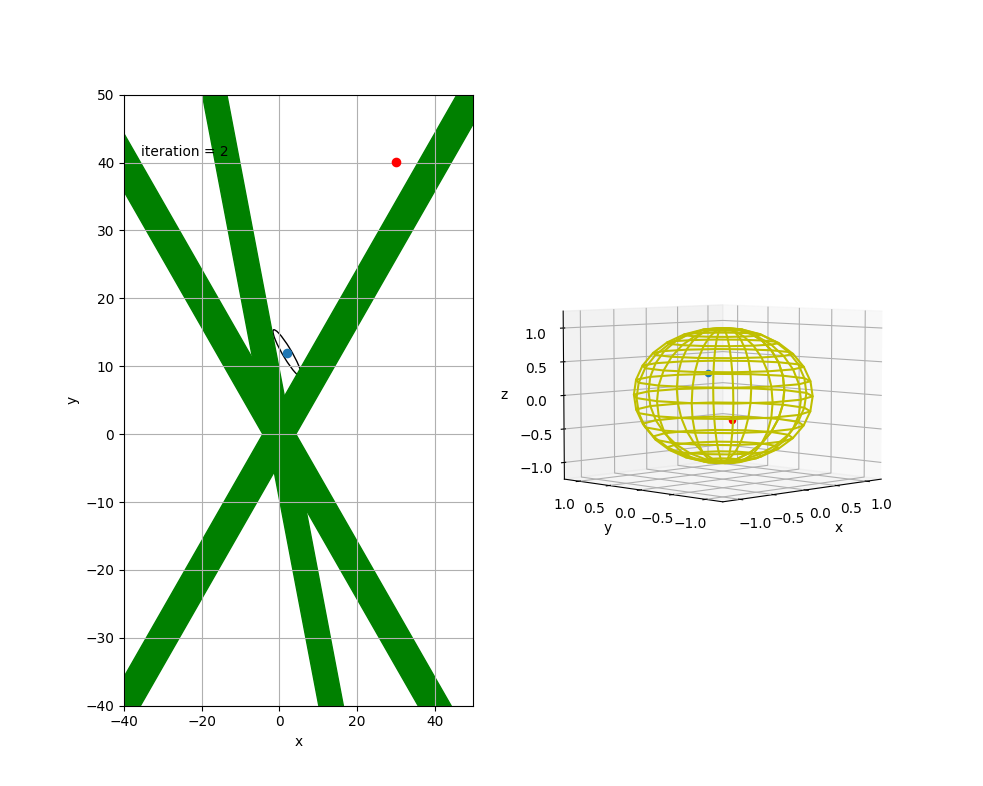

[2.55990927e-04 3.42452545e-09]


In [40]:
%matplotlib notebook
from Visualization.visualization import SubplotAnimationWithDiscontinuityRegions

ani = SubplotAnimationWithDiscontinuityRegions(results,
                                               parameterMagnitude, 
                                               targetParameter, 
                                               finalSolution, 
                                               differentialParameterAlongV, 
                                               differentialSolutionAlongV,
                                               eps)

ani.show()